# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

In [2]:
# !pip install -q kaggle
# !mkdir %userprofile%\.kaggle
# !copy kaggle.json %userprofile%\.kaggle\
# !chmod 600 %userprofile%\.kaggle\kaggle.json
# !kaggle datasets download -d jessicali9530/celeba-dataset

# Dataset Preparation

In [2]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./celeba-dataset/img_align_celeba/img_align_celeba", 
    label_mode=None, 
    image_size=(IM_SHAPE[0], IM_SHAPE[1]), 
    batch_size=BATCH_SIZE
)

Found 202599 files belonging to 1 classes.


In [4]:
def preprocess(image):
    return tf.cast(image, tf.float32) / 127.5 - 1.0

In [5]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
for d in train_dataset.take(1):
    print(d.shape)

(128, 64, 64, 3)


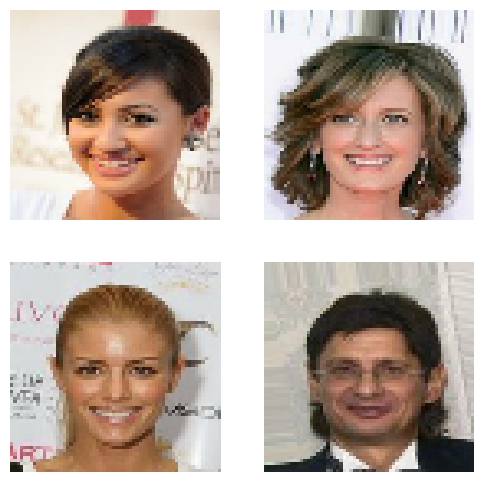

In [7]:
plt.figure(figsize = (6,6))
k=0
n = 4
for i in range(n):
    ax = plt.subplot(2,2, k+1)
    plt.imshow((d[i]+1)/2)
    plt.axis("off")
    k+=1

# Modeling

## Generator

In [8]:
def create_generator():
    generator=tf.keras.Sequential([
      Input(shape=(LATENT_DIM,)),
      Dense(4*4*LATENT_DIM),
      Reshape((4,4,LATENT_DIM)),

      Conv2DTranspose(512,kernel_size=4,strides=2, padding='same'),
      BatchNormalization(),
      LeakyReLU(0.2),

      Conv2DTranspose(256,kernel_size=4,strides=2, padding='same'),
      BatchNormalization(),
      LeakyReLU(0.2),

      Conv2DTranspose(128,kernel_size=4,strides=2, padding='same'),
      BatchNormalization(),
      LeakyReLU(0.2),

      Conv2DTranspose(3,kernel_size=4,strides=2, activation=tf.keras.activations.tanh, padding='same'),

    ],name='generator')
    return generator

In [9]:
generator = create_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        819712    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      20

## Discriminator

In [10]:
def create_discriminator():
    discriminator=tf.keras.Sequential([
      Input(shape=(IM_SHAPE[0],IM_SHAPE[1],3)),

      Conv2D(64,kernel_size=4,strides=2, padding='same'),
      LeakyReLU(0.2),

      Conv2D(128,kernel_size=4,strides=2, padding='same'),
      BatchNormalization(),
      LeakyReLU(0.2),

      Conv2D(256,kernel_size=4,strides=2, padding='same'),
      BatchNormalization(),
      LeakyReLU(0.2),

      Conv2D(1,kernel_size=4,strides=2, padding='same'),

      Flatten(),
      Dense(1,activation='sigmoid')


    ],name='discriminator')
    return discriminator

In [11]:
discriminator = create_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                     

## Custom Callback

In [12]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self,latent_dim=100):
        super(ShowImage,self).__init__()
        self.latent_dim = latent_dim
        
    def on_epoch_end(self,epoch,logs=None):
        noise = tf.random.normal(shape=(36,self.latent_dim))
        out = self.model.generator(noise)
        n = 6
        k = 0
        plt.figure(figsize=(16,16))
        for i in range(n):
            for j in range(n):
                ax = plt.subplot(n,n,k+1)
                plt.imshow((out[k]+1)/2.)
                plt.axis('off')
                k+=1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))

## Training

In [13]:
class GAN(tf.keras.Model):
    def __init__(self):
        super(GAN,self).__init__()
        self.generator = create_generator()
        self.discriminator = create_discriminator()
        
    def compile(self,g_optimizer,d_optimizer,loss_fn):
        super(GAN,self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')
    
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]
    
    def train_step(self,real_images):
        batch_size = tf.shape(real_images)[0]
        ###################### Discriminator
        d_random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
        d_fake_images=self.generator(d_random_noise)
        real_labels = tf.ones(shape=(batch_size,1))+0.25*tf.random.uniform(shape=(batch_size,1),minval=-1,maxval=1.)
        d_fake_labels = tf.zeros(shape=(batch_size,1))+0.25*tf.random.uniform(shape=(batch_size,1),minval=0,maxval=1.)
        
        with tf.GradientTape() as d_tape:
            d_fake_preds = self.discriminator(d_fake_images)
            d_loss_fake = self.loss_fn(d_fake_labels,d_fake_preds)
            
            real_preds = self.discriminator(real_images)
            d_loss_real = self.loss_fn(real_labels,real_preds)
        
            d_loss = d_loss_fake+d_loss_real
            
        d_partial_grads = d_tape.gradient(d_loss,self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(d_partial_grads,self.discriminator.trainable_weights))
        self.d_loss_metric.update_state(d_loss)
        
        ########################################################
        #################Generator
        g_random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
        flipped_fake_labels = tf.ones(shape=(batch_size,1))
        
        with tf.GradientTape() as g_tape:
            g_fake_images=self.generator(g_random_noise)
            g_fake_preds = self.discriminator(g_fake_images)
            g_loss = self.loss_fn(flipped_fake_labels,g_fake_preds)
        
        g_partial_grads = g_tape.gradient(g_loss,self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_partial_grads,self.generator.trainable_weights))
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss':self.d_loss_metric.result(),
                'g_loss':self.g_loss_metric.result()}

In [21]:
def plot_history(history):
    plt.plot(history.history['d_loss'])
    plt.plot(history.history['g_loss'])
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['d_loss', 'g_loss'], loc='upper left')
    plt.show()

In [14]:
gan=GAN()
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [15]:
!mkdir generated

A subdirectory or file generated already exists.


In [ ]:
EPOCHS=30
history=gan.fit(
    train_dataset.take(150),
    epochs=EPOCHS,
    callbacks=[ShowImage(LATENT_DIM)]
)

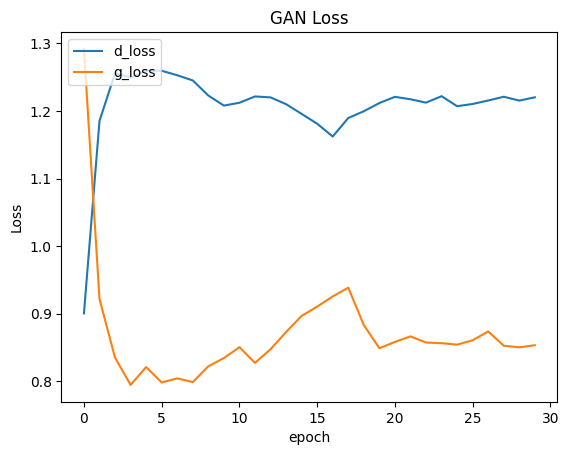

In [22]:
plot_history(history)

In [ ]:
history_2=gan.fit(
    train_dataset.take(150),
    epochs=EPOCHS+EPOCHS,
    initial_epoch=history.epoch[-1],
    callbacks=[ShowImage(LATENT_DIM)]
)


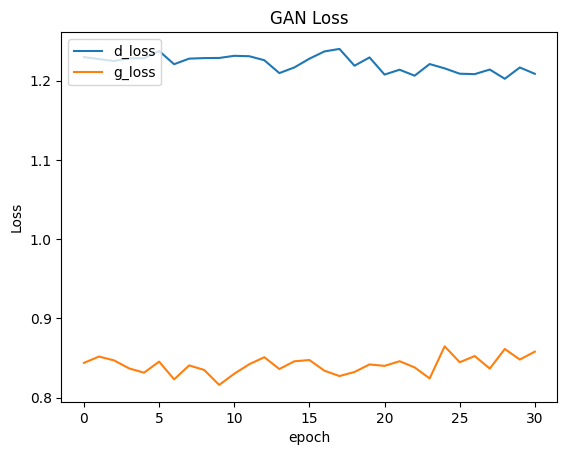

In [23]:
plot_history(history_2)

In [ ]:
history_3=gan.fit(
    train_dataset.take(300),
    epochs=history_2.epoch[-1]+50,
    initial_epoch=history_2.epoch[-1],
    callbacks=[ShowImage(LATENT_DIM)]
)


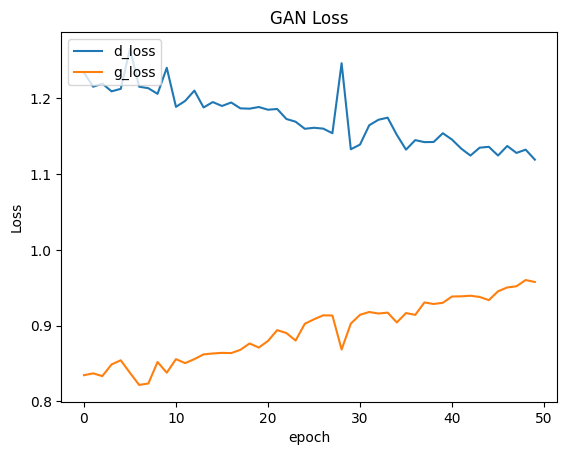

In [24]:
plot_history(history_3)

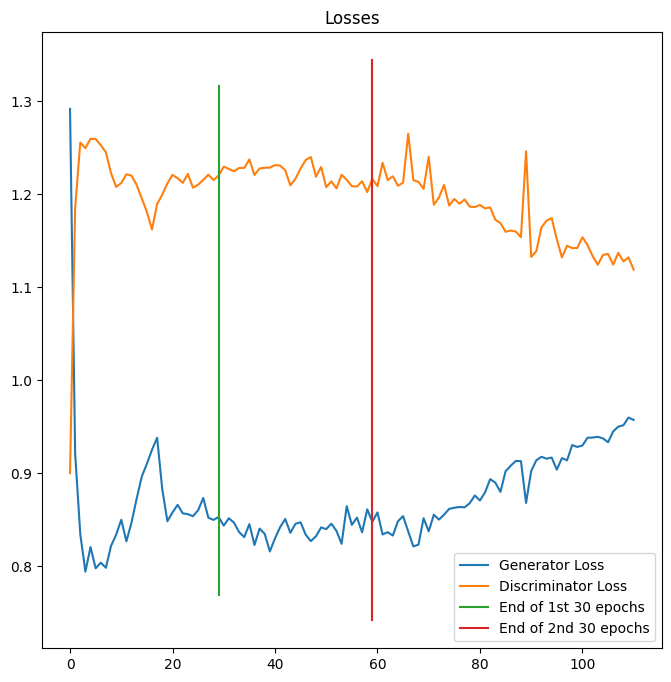

In [27]:

# Get original history measurements
history_1_g_loss = history.history["g_loss"]
history_1_d_loss = history.history["d_loss"]

history_2_g_loss = history_2.history["g_loss"]
history_2_d_loss = history_2.history["d_loss"]

# Combine original history with new history
history_3_g_loss = history_3.history["g_loss"]
history_3_d_loss = history_3.history["d_loss"]

total_g_loss = history_1_g_loss + history_2_g_loss + history_3_g_loss
total_d_loss = history_1_d_loss + history_2_d_loss + history_3_d_loss


# Make plots
plt.figure(figsize=(8, 8))
plt.plot(total_g_loss, label='Generator Loss')
plt.plot(total_d_loss, label='Discriminator Loss')
plt.plot([history.epoch[-1], history.epoch[-1]],
          plt.ylim(), label='End of 1st 30 epochs') 
plt.plot([history_2.epoch[-1], history_2.epoch[-1]],
          plt.ylim(), label='End of 2nd 30 epochs')
plt.legend(loc='lower right')
plt.title('Losses')

plt.show()